<a href="https://colab.research.google.com/github/himalayahall/LargeLanguageModels/blob/main/Building_Micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is an attempt to follow along with [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0) YouTube lecture by Andrej Karpathy.

Shortcuts:

    Ctrl + M + A         : insert cell above
    Ctrl + M + B         : insert cell below
    CRL + M + Y          : change cell to code
    CTRL + M + M         : change cell to markdown
    CTRL + Shift + Enter :  execute cell

Python dunder methods

    https://mathspp.com/blog/pydonts/dunder-methods#:~:text=In%20Python%2C%20dunder%20methods%20are,__%20or%20__add__%20.

In [ ]:
import math
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(5.0)

60.0

Text(0, 0.5, 'f(x)')

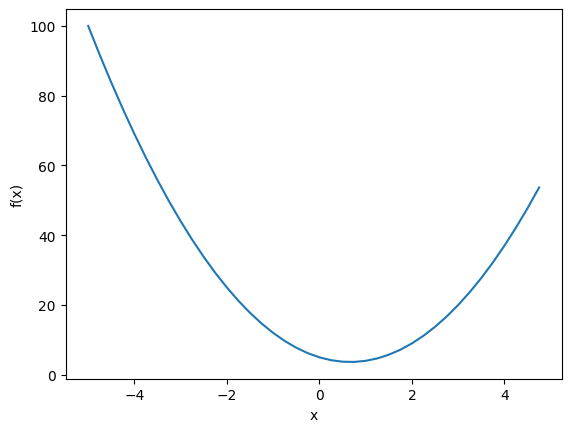

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.xlabel('x')
plt.ylabel('f(x)')

The derivative of a function f(x) at any given point x is the change in function value from x -> x + h, where h is a small increment, over the increment. In other words, df(x) = (f(x + h) - f(x)) / h.

For example, at x = 3.0, the derivative is (approx) 14.0 (see below). We can verify this by differentiating our function w.r.t (with respect to) x, we get 6x - 4 or 18 - 4, which is indeed 14.

In [ ]:
h = 0.0000001
def df(x):
  print(x, (f(x + h) - f(x)) / h)

for x in xs:
  df(x)

-5.0 -33.999999828893124
-4.75 -32.49999991794539
-4.5 -30.999999864889105
-4.25 -29.499999811832822
-4.0 -27.999999616667992
-3.75 -26.499999634665983
-3.5 -24.999999652663973
-3.25 -23.49999959960769
-3.0 -21.999999688659955
-2.75 -20.499999635603672
-2.5 -18.999999653601662
-2.25 -17.499999671599653
-2.0 -15.999999689597644
-1.75 -14.499999707595634
-1.5 -12.999999725593625
-1.25 -11.499999708064479
-1.0 -9.999999690535333
-0.75 -8.499999690769755
-0.5 -6.9999996998859615
-0.25 -5.499999700120384
0.0 -3.999999700354806
0.25 -2.4999997005892283
0.5 -0.9999997008236505
0.75 0.5000002989419272
1.0 2.000000298707505
1.25 3.500000307354867
1.5 5.00000029823866
1.75 6.500000298004238
2.0 8.000000288888032
2.25 9.500000306417178
2.5 11.000000288419187
2.75 12.500000252657628
3.0 14.000000305713911
3.25 15.50000028771592
3.5 17.00000026971793
3.75 18.50000025171994
4.0 20.000000375830496
4.25 21.50000042888678
4.5 23.000000339834514
4.75 24.50000025078225


Notice that the sign positive/negative of the derivative tells us whether f(x) will go up (down) down as x goes up (down). 

For example, at x = -1.5 the sign of the derivative (-13) is negative, which tells us that increasing x will decrease the value of f(x). The derivative is 0.0 at x = 2/3.
 

In [ ]:
df(2/3)

0.6666666666666666 2.9753977059954195e-07


In [ ]:
# slightly more complex case
def f(a, b, c):
  return a * b + c

a = 2.0
b = -3.0
c = 10.0
print(f(a, b, c))

4.0


Let's compute the slope of this function at a = 2.0, b = -3.0, c = 10.0. We see that the slope w.r.t. a is negative; in other words, increasing a will decrease the value of the function. Slope is positive w.r.t. to b and c; increasing b or c with increase the value of the function.

In [ ]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0
d1 = f(a, b, c)

# calculate slope w.r.t. a
a = a + h
d2 = f(a, b, c)

print(f"d1 = {d1}, d2 = {d2}, slope w.r.t a = {(d2 - d1) / h}")

# calculate slope w.r.t. b
a = 2.0
b = -3.0
c = 10.0
d1 = f(a, b, c)

b = b + h
d2 = f(a, b, c)

print(f"d1 = {d1}, d2 = {d2}, slope w.r.t b = {(d2 - d1) / h}")

# slope w.r.t. c
a = 2.0
b = -3.0
c = 10.0
d1 = f(a, b, c)

c = c + h
d2 = f(a, b, c)

print(f"d1 = {d1}, d2 = {d2}, slope w.r.t c = {(d2 - d1) / h}")

d1 = 4.0, d2 = 3.999699999999999, slope w.r.t a = -3.000000000010772
d1 = 4.0, d2 = 4.0002, slope w.r.t b = 2.0000000000042206
d1 = 4.0, d2 = 4.0001, slope w.r.t c = 0.9999999999976694


Now that we have some intuitive sense of the derivative, we will move on to neural networks. We will build some data structures to enable us to visualize the complexity and computation inside NNs.

In [ ]:
class Value:

  def __init__(self, data, _children=(), _op = '', _label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda : None
    self._prev = set(_children)
    self._op = _op
    self._label = _label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
      other = other if isinstance(other, Value) else Value(other)
      out = Value(self.data + other.data, _children=(self, other), _op='+')

      def _backward():
        self.grad += 1.0 * out.grad
        other.grad += 1.0 * out.grad

      out._backward = _backward
      return out 

  def __radd__(self, other):
      return self + other  
      
  def __iadd__(self, other):
      return self + other   

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
      return self + (-other)
  
  def __rsub__(self, other):
       return self - other

  def __isub__(self, other):
      return self - other

  def __mul__(self, other):
      other = other if isinstance(other, Value) else Value(other)
      out = Value(self.data * other.data, _children=(self, other), _op='*')
      
      def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad        
      
      out._backward = _backward
      return out


  def __rmul__(self, other):
      return self * other

  def __imul__(self, other):
       return self * other

  def __pow__(self, other):
      assert isinstance(other, (int, float)) # only supporting int/float for now
      out = Value(self.data ** other, _children=(self,), _op=f'**{other}')
      
      def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad

      out._backward = _backward

      return out
       
  def __truediv__(self, other):
      return self * other**-1
      #other_val = other.data if isinstance(other, Value) else other
      #out = Value(self.data / other_val, _children=(self, other), _op='/')
      #return out

  def __rtruediv__(self, other):
      return self / other

  def tanh(self):
    x = self.data
    e = math.exp(2*x)
    t = (e - 1) / (e + 1)
    out = Value(t, _children=(self, ), _op='tanh')
    
    def _backward():
        self.grad += (1.0 - t**2) * out.grad

    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), _op='exp')

    def _backward():
        self.grad = out.data * out.grad # derivative of e^x is e^x, which we calculated above as math.exp(x)
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
from graphviz import Digraph
 
def trace(root):

  # set of all edges and nodes in a graph
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    #print(n)
    dot.node(name = uid, label = '{ %s | data %.4f | grad %.4f }' % (n._label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
a = Value(2.0, _label='a')
b = Value(-3.0, _label='b')
c = Value(10.0, _label='c')
e = a * b; e._label = 'e'
d =e + c; d._label = 'd'
f = Value(-2.0, _label='f')
L = d * f; L._label = 'L'


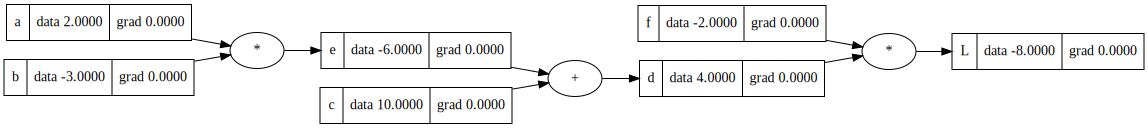

In [ ]:
draw_dot(L)

    dL/dL = 1



In [ ]:
L.grad = 1.0

L = d * f

      dL/dd = (f(x + h) - f(x)) / h
            = (((d + h) * f) - (d * f)) / h
            = (df + hf - df) / h
            = (hf) / h
            = f

And by symmetry

      dL/df = (f(x + h) - f(x)) / h
            = ((d * (f + h)) - (d * f)) / h
            = (df + dh - df) / h
            = (dh) / h
            = d

In [ ]:
d.grad = f.data
f.grad = d.data

d = c + e

    dd/dc = (f(x+h) - f(x)) / h
          = ((c + h + e) - (c + e) / h
          = (c + h + e - c - e) /h
          = h / h
          = 1

and by symmetry

    dd/de = (f(x+h) - f(x)) / h
          = ((c + e + h) - (c + e) / h
          = (c + e + h - c - e) /h
          = h / h
          = 1

Finally, by the chain rule

    dL/dc = dd/dc * DL/dd
          = 1 * -2.0
          = -2.0

and by symmetry

    dL/de = dd/de * DL/dd
          = 1 * -2.0
          = -2.0



In [ ]:
c.grad = -2.0
e.grad = -2.0

Finally, e = a * b

    de/da = (f(x+h) - f(x)) / h
          = (((a + h) * b) - (a * b) / h
          = (ab + bh - ab) /h
          = bh / h
          = b
          = -3.0

and by symmetry

    de/db = (f(x+h) - f(x)) / h
          = ((a * (b + h)) - (a * b) / h
          = (ab + ah - ab) /h
          = ah / h
          = a
          = 2.0

Finally, by the chain rule

    dL/da = de/da * DL/de
          = -3 * -2.0
          = 6.0

and by symmetry

    dL/db = de/db * DL/de
          = 2.0 * -2.0
          = -4.0

In [ ]:
a.grad = 6.0
b.grad = -4.0

That's it, we have done one forward pass and one backprop!

In [ ]:
draw_dot(L)
L.data

-8.0

Nudging the variables - e.g. a, b, c, f - in the direction of their gradient will increase the value of the final output.

In [ ]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)


-7.286496


Now let's build out a slightly more complex model, a **neural network**

A simple model of a [neuron](https://www.google.com/search?q=cs231n+neuron&client=safari&rls=en&sxsrf=APwXEdfm0BeLCEu6FoTYO-BBgzglEPgg1w:1683322822441&source=lnms&tbm=isch&sa=X&ved=2ahUKEwjk2_2Wkt_-AhWCk4kEHeEYAaMQ0pQJegQIBBAE&biw=1920&bih=1080&dpr=2#imgrc=EErT7l9gJn-7uM) has inputs flowing into synapses, each synapse has weights, inputs are multiplied by the respective weights ($w_0x_0, w_1x_1, w_2x_2, ...$), and summed up along with the bias:

$\sum \limits_{i} w_ix_i + b$

Then an activation function, e.g. $tanh$, is applied to the sum:

$f(\sum \limits_{i} w_ix_i + b)$

$tanh$ is a *squashing function*, it squashes its inputs between [-1.0, 1.0]


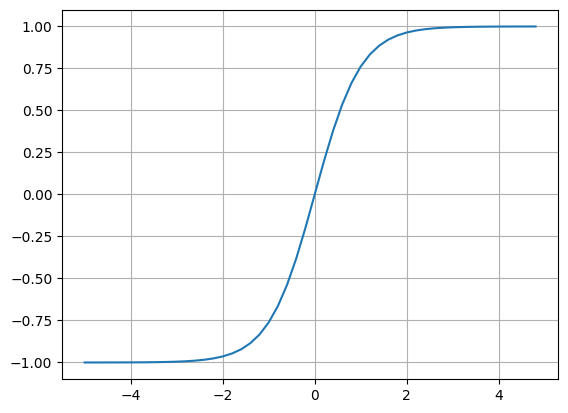

In [ ]:
x = np.arange(-5, 5, 0.2)
plt.plot(x, np.tanh(x))
plt.grid()

In [ ]:
# input x1, x2 - a 2-input neuron
x1 = Value(2.0, _label='x1')
x2 = Value(0.0, _label='x2')

# weights
w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')

# bias
b = Value(6.8813735870195432, _label = 'b')

x1w1 = x1*w1; x1w1._label = 'x1w1'
x2w2 = x2*w2; x2w2._label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n._label = 'n'
o = n.tanh(); o._label = 'o'

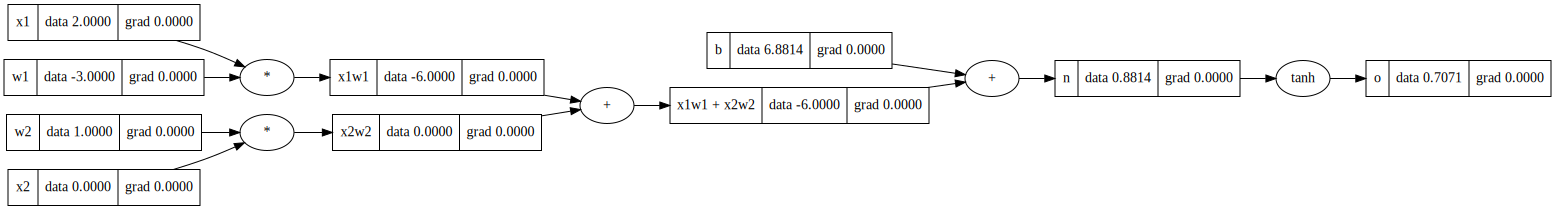

In [ ]:
draw_dot(o)

Let's backprop through our neural network. As before, $\frac{\partial o}{\partial o} = 1$.

$o = tanh(n)$


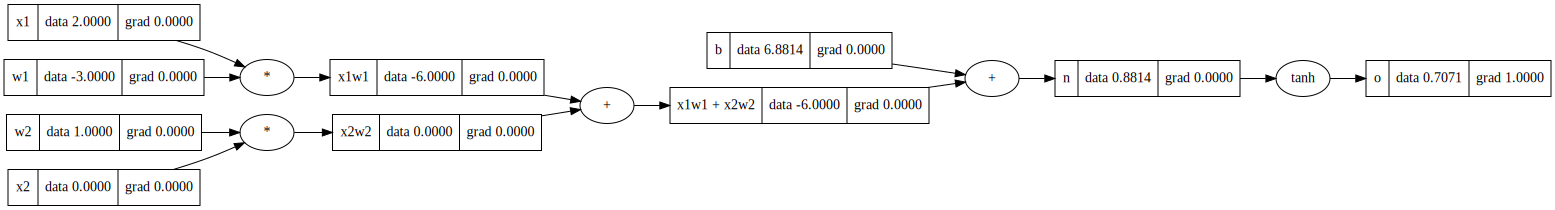

In [ ]:
o.grad = 1.0
draw_dot(o)


$\frac{\partial o}{\partial n} = 1 - tanh(n)^2$

but we know that $o = tanh(n)$, so

$\frac{\partial o}{\partial n} = 1 - o^2$

In [ ]:
n.grad = 1.0 - o.data**2
n.grad

0.4999999999999999

Going backward, we have a $+$ node. From previous example, we know a $+$ node is just a distributor of the parent node gradient to it's children nodes. So, the gradient of $n$ is distributed to nodes $[b]$ and  $[x1w1 + x2w2]$

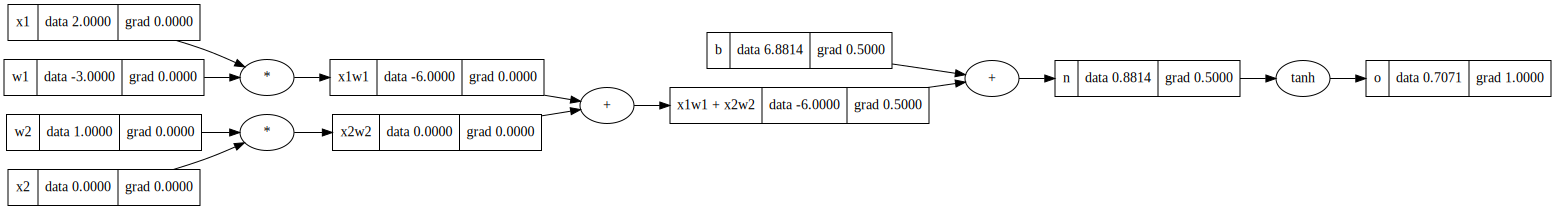

In [ ]:
b.grad = n.grad; x1w1x2w2.grad = n.grad
draw_dot(o)

Going backward, we have another  +  node. So, the gradient of $[𝑥1𝑤1+𝑥2𝑤2]$  is distributed to nodes  $[x2w2]$  and  $[𝑥1𝑤1]$ 

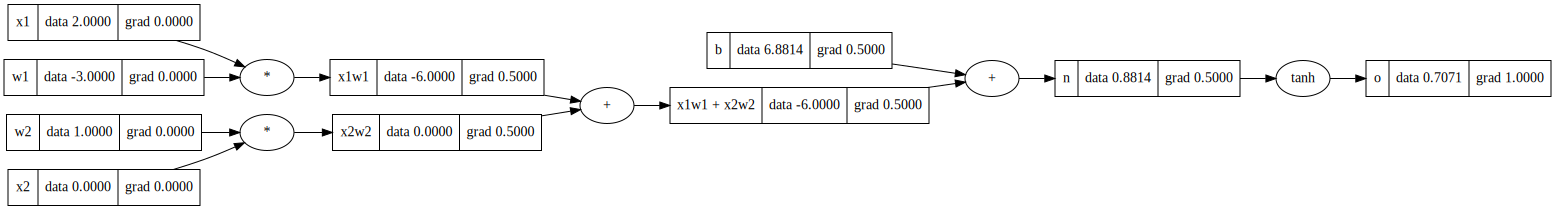

In [ ]:
x1w1.grad = x1w1x2w2.grad; x2w2.grad = x1w1x2w2.grad
draw_dot(o)

Now we have two $*$ nodes.

We know:

$x2.grad = x2w2.grad * w2.data$ and 

$w2.grad = x2w2.grad * x2.data$

and

$x1.grad = x2w2.grad * w1.data$ and 

$w1.grad = x2w2.grad * x1.data$

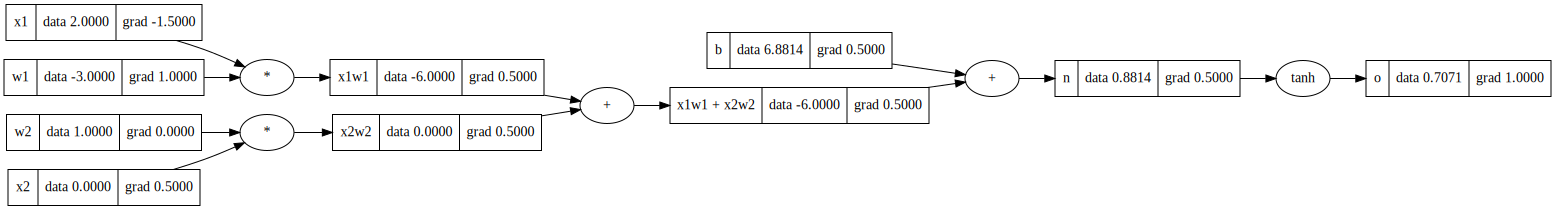

In [ ]:
x2.grad = x2w2.grad * w2.data; w2.grad = x2w2.grad * x2.data

x1.grad = x2w2.grad * w1.data; w1.grad = x2w2.grad * x1.data

draw_dot(o)

That's it. We have done a backprop through the NN.

We have also created all the machinery in Value class to compute gradients. For example, calling ```n.backward()```  will compute the gradient for ```n```. And calling ```x1w1x2w2``` will compute the gradient for ```x1we1x2w2```.

That's great but of course we don't want to call ```.backward()``` for every node explicitly. We woiuld like to call ```o.backward()``` and have that propagate throughout the network automatically.

To make that work we need to make sure that ```.backward()``` for any node is called only after the gradient of all it's downstream nodes has been calculated.

To make that happen, we create a topological sort.

In [ ]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

Now we can iterate over the nodes in ```topo``` in reverse order and call ```.backward()``` for each visited node.

In [ ]:
o.grad = 1.0
o._backward()

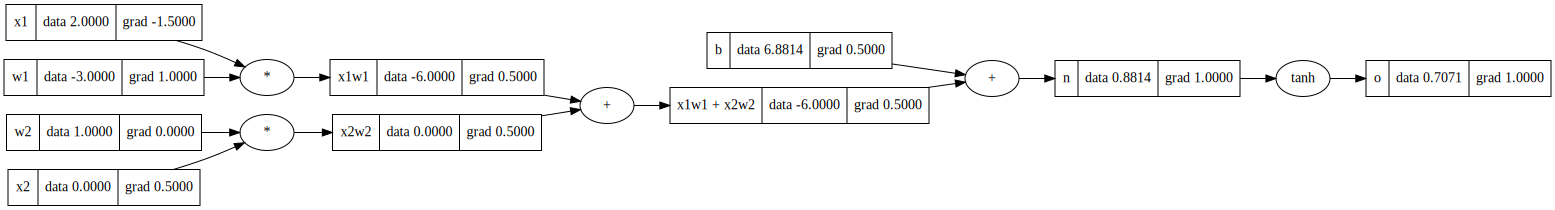

In [ ]:
draw_dot(o)

We will take this code and make it part of the ```Value``` class. And that's it. We have build the machinery for backprop!

In [ ]:
def lol():

  h = 0.00001

  a = Value(2.0, _label='a')
  b = Value(-3.0, _label='b')
  c = Value(10.0, _label='c')
  e = a * b; e._label = 'e'
  d =e + c; d._label = 'd'
  f = Value(-2.0, _label='f')
  L = d * f; L._label = 'L'
  L1 = L.data

  a = Value(2.0, _label='a')
  b = Value(-3.0, _label='b')
  c = Value(10.0, _label='c')
  e = a * b; e._label = 'e'
  d =e + c; d._label = 'd'
  f = Value(-2.0 + h, _label='f')
  L = d * f; L._label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

lol()

4.000000000026205


Now, let's redefine $tanh(x)$

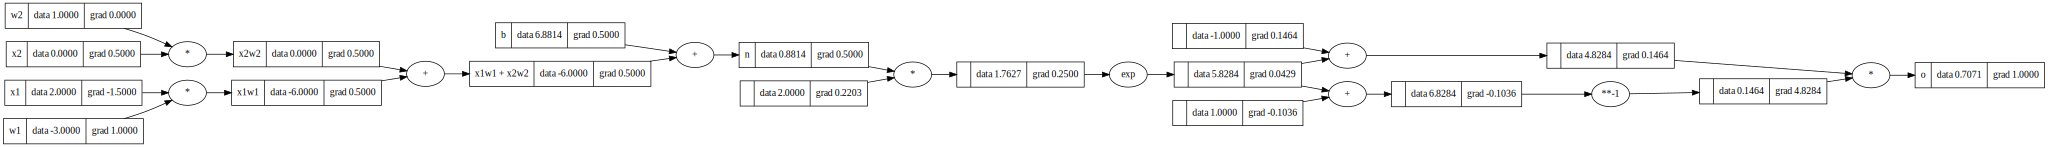

In [ ]:
# input x1, x2 - a 2-input neuron
x1 = Value(2.0, _label='x1')
x2 = Value(0.0, _label='x2')

# weights
w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')

# bias
b = Value(6.8813735870195432, _label = 'b')

x1w1 = x1*w1; x1w1._label = 'x1w1'
x2w2 = x2*w2; x2w2._label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n._label = 'n'

# ------
e = (2*n).exp()
o = (e - 1) / (e + 1); o._label = 'o'
# ------
o.backward()
draw_dot(o)

Now, let us do the exact same computation using a modern deep-learning library, PyTorch.

In [ ]:
import torch

# input x1, x2 - a 2-input neuron
x1 = torch.tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.tensor([0.0]).double(); x2.requires_grad = True

# weights
w1 = torch.tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.tensor([1.0]).double(); w2.requires_grad = True

# bias
b = torch.tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())

o.backward()

print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())



0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


Now we model a NN using Torch.

In [ ]:
# Single neuron
class Neuron:
  def __init__(self, nin : int):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    # w * x + b
    act = sum([wi * xi for wi, xi in zip(self.w, x)], start=self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin: int, nouts: int):
    self.neurons = [Neuron(nin) for _ in range(nouts)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    # return [n.parameters() for n in self.neurons]
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, nin: int, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
     # return [p for layer in self.layers for p in layer.parameters()]
    return [layer.parameters() for layer in self.layers]





---



In [ ]:
# # single neuron
# x = [1.0, 2.0]
# n = Neuron(2)
# print(f'neuron: {n(x)}')

# l = Layer(2, 5)
# print(f'layer: {l(x)}')

# # # MLP - 3 inputs, 2 layers with 4 neurons each, 1 output
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.8465093674306605)

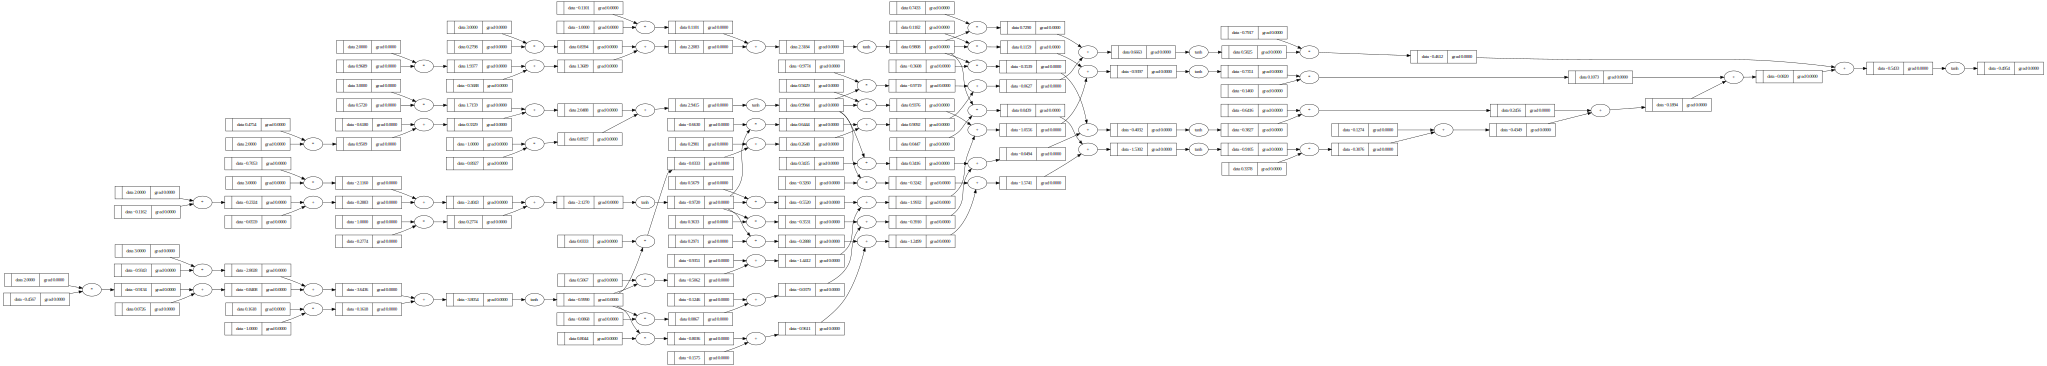

In [ ]:
draw_dot(n(x))

In [ ]:
# setup inputs/output
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [ ]:
# get predictions and compute loss (regression model)
ypred = [n(x) for x in xs]

# ygt - y ground truth
loss = sum([np.square(yout - ygt) for ygt, yout in zip(ys, ypred)])
loss

Value(data=2.0275129625216324)

In [ ]:
# backward pass through NN
loss.backward()

In [ ]:
n.layers[0].neurons[0].w[0].grad

0.7184447127446947

In [ ]:
n.layers[0].neurons[0].w[0].data

0.7058521853127262

In [ ]:
# change parameters based on gradient
for p in n.parameters():
  # the negative sign is there because: a negative (positive) gradient is saying that 
  # increasing (decreasing) the value will decrease increase) the loss. 
  p.data += -0.01 * p.grad

In [ ]:
# calculate new loss - we expect it to be smaller than before
ypred = [n(x) for x in xs]
loss = sum([np.square(yout - ygt) for ygt, yout in zip(ys, ypred)])
loss

Value(data=2.0275129625216324)

In [ ]:
# once more
loss.backward()
for p in n.parameters():
  # the negative sign is there because: a negative (positive) gradient is saying that 
  # increasing (decreasing) the value will decrease increase) the loss. 
  p.data += -0.01 * p.grad

ypred = [n(x) for x in xs]
loss = sum([np.square(yout - ygt) for ygt, yout in zip(ys, ypred)])
loss

Value(data=1.6004154961621648)

In [ ]:
# we can keep repeating this process until loss is (close to) 0
# This is Gradient Descent

# Let's write the training loop
for k in range(10):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum([np.square(yout - ygt) for ygt, yout in zip(ys, ypred)])

  # zero grad
  for p in n.parameters():
    p.grad = 0.0

  # backward pass
  loss.backward()

  # update parameters
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)

ypred

0 0.00015937830006109837
1 0.0001593153801636591
2 0.0001592525085305345
3 0.00015918968510686605
4 0.00015912690983788097
5 0.00015906418266889514
6 0.00015900150354529512
7 0.00015893887241256023
8 0.00015887628921624597
9 0.00015881375390199227


[Value(data=0.9957961002761964),
 Value(data=-0.9954239609908654),
 Value(data=-0.9924528151175273),
 Value(data=0.9920475885197728)]